In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve, make_swiss_roll
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


In [2]:

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [3]:

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


### 1. Data preprocessing
The dataset is based on the simulation model below. The healthy dataset is data_boh.mat and the faulty dataset is data_bou.mat. For each dataset, it consists of 4000 univariate samples with length of 512.

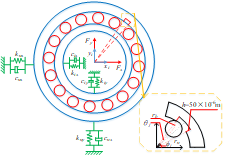

In [4]:
import scipy.io as scio
from sklearn.model_selection import train_test_split
import pandas as pd

# dict_o = scio.loadmat(r'D:/Work in EPFL/diffusion_model/Ramanujan_Dictionary_DDPM/IMS_data/N2_data_C3_.mat')
#dict_o = pd.read_csv('AE_Diffusion/AE_data_ims/data_f.csv')
dict_oh = scio.loadmat('AE_Diffusion/AE_data_ims/data_boh.mat')
data_oh = dict_oh['d1_']
# y_oh = np.zeros(600,1)
dict_ou = scio.loadmat('AE_Diffusion/AE_data_ims/data_bou.mat')
data_ou = dict_ou['d1_d']
data_o = np.vstack((data_oh[0:3000,:],data_ou[0:3000,:]))
# y_o = np.ones(600,1)
def normalize(data):
    data_ = (data-np.min(data))/(np.max(data)-np.min(data))
    return data_

data_ = np.zeros([1200,5,512])
for i in range(1200):
  for j in range(5):
    data_[i,j,:] = normalize(data_o[5*i+j,:])
data_tv = data_
# data_test  = data_1[1000:-1,:,:]
yh = np.zeros(600)
yu = np.ones(600)
y_ = np.concatenate((yh,yu))
data_tr,data_va,y_1,y_v = train_test_split(data_tv, y_, test_size=0.2, random_state=42)
# data_tr = data_tr.view(-1,2048)
# data_va = data_va.view(-1,2048)

batch_size = 16 #考虑到样本总数仅为1000个,batch_size设定为64个
# dataset放到dataloader中
dataset_tensor = torch.utils.data.TensorDataset(torch.tensor(data_tr,dtype=torch.float32).cuda(),torch.tensor(y_1,dtype = torch.float32).cuda())
#dataloader_1 = torch.utils.data.DataLoader(torch.tensor(data_tr,dtype=torch.float32).cuda(), batch_size=batch_size, shuffle=True)
dataloader_1 = torch.utils.data.DataLoader(dataset_tensor,batch_size=batch_size, shuffle=True)

### 2. Noise strategy
I adopt the linear noise strategy.

In [5]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [6]:

num_steps = 1000
#指定每一步的beta的具体数值
# betas = torch.linspace(-6,6,num_steps)
# betas = torch.sigmoid(betas)*(0.5e-2-1e-5)+1e-5
betas = linear_beta_schedule(num_steps)
# betas = quadratic_beta_schedule(num_steps)
# betas = torch.linspace(-0.0001,0.02, num_steps)
alphas = 1-betas


In [7]:
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
#之后公式中需要使用的log(1-alpha_p)
one_minus_alphas_bar_log = torch.log(1-alphas_prod)
#之后公式中需要使用的sqrt(1-alpha_p)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)


In [8]:
assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([1000])


3. Forward process function

In [9]:
def q_x(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    #生成正态分布采样
    noise = torch.randn_like(x_0)
    #得到均值方差
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    #根据x0求xt
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声


### 4. Network structure Based on the encoder of the Transformer structure.
I tried different structures and make ablation experiments to simplify the network structure to generate the high-fidelity samples and also meanwhile cancel some unnecessary part to save training time.

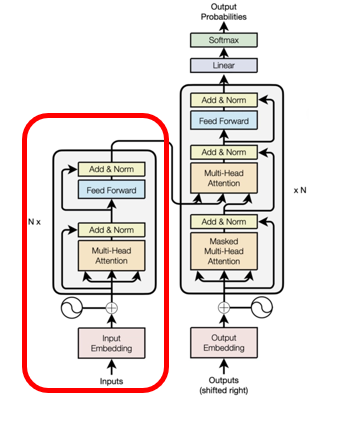




### Non-conditional and Non-guidance version
This is the old version of the classifier guidance, which does not really work well on the bearing simulation signal.

> 缩进块



In [10]:
# import torch
# import torch.nn.functional as F
# from torch import nn


# class CustomModel(nn.Module):
#     def __init__(self, n_steps, input_size, hidden_size, num_heads):
#         super(CustomModel, self).__init__()

#         # Linear layer after input
#         self.linear1 = nn.Linear(input_size, hidden_size)

#         # Multi-head attention layer
#         self.multihead_attention1 = nn.MultiheadAttention(hidden_size, num_heads)

#         # Linear layer after multi-head attention
#         self.linear2 = nn.Sequential(
#             nn.Linear(hidden_size, input_size),
#             # nn.BatchNorm1d(5),
#             #nn.ReLU()
#             nn.SiLU()
#             )

#         self.step_embeddings1 = nn.Embedding(n_steps,input_size)
#         self.step_embeddings2 = nn.Embedding(n_steps,input_size)
#         self.step_embeddings3 = nn.Embedding(n_steps,input_size)

#         self.Layernorm_ = nn.LayerNorm(512)

#     def forward(self, x, t):
#         # Apply the first linear layer
#         b_s = x.shape[0]
#         seq_len = x.shape[1]
#         t_ = t*torch.ones(1,seq_len).type(torch.int).cuda()
#         x0 = x
#         # x = self.linear1(x)
#         # Transpose x to have shape (seq_len, batch_size, input_size)
#         x = x.permute(1, 0, 2)
#         # Apply multi-head attention
#         x, _ = self.multihead_attention1(x, x, x)
#         x = x.permute(1, 0, 2)
#         x = x + self.step_embeddings1(t_)
#         x = x + x0
#         x = self.Layernorm_(x)

#         x1 = x
#         x = self.linear2(x)
#         x = x + self.step_embeddings2(t_)
#         x = x+x1
#         x = self.Layernorm_(x)
#         return x




### introduce the conditional mechanism
Here we introduce the classifier free guidance, which did not really train a classifier. Instead, the condition is taken into consideration as a random variable during the training process.

In [68]:
import torch
import torch.nn.functional as F
from torch import nn


class CustomModel(nn.Module):
    def __init__(self, n_steps, input_size, hidden_size, num_heads):
        super(CustomModel, self).__init__()

        # Linear layer after input
        self.linear1 = nn.Linear(input_size, hidden_size)

        # Multi-head attention layer
        self.multihead_attention1 = nn.MultiheadAttention(hidden_size, num_heads)

        # Linear layer after multi-head attention
        self.linear2 = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            # nn.BatchNorm1d(5),
            #nn.ReLU()
            nn.SiLU()
            )

        self.step_embeddings1 = nn.Embedding(n_steps,input_size)
        self.step_embeddings2 = nn.Embedding(n_steps,input_size)
        self.step_embeddings3 = nn.Embedding(n_steps,input_size)

        self.y_embeddings1 = nn.Embedding(2,input_size)
        self.y_embeddings2 = nn.Embedding(2,input_size)
        self.y_embeddings3 = nn.Embedding(2,input_size) # the first dimension is set as 2 because there are two labels in this case


        self.Layernorm_ = nn.LayerNorm(512)

    def forward(self, x, t , y = None, uncon_rate = 0.1):
        unconditional = torch.rand(1)<=uncon_rate
        # Apply the first linear layer
        b_s = x.shape[0]
        seq_len = x.shape[1]
        t_ = t*torch.ones(1,seq_len).type(torch.int).cuda()
        #y_ = y*torch.ones(1,seq_len).type(torch.int).cuda()

        x0 = x
        # x = self.linear1(x)
        # Transpose x to have shape (seq_len, batch_size, input_size)
        x = x.permute(1, 0, 2)
        # Apply multi-head attention
        x, _ = self.multihead_attention1(x, x, x)
        x = x.permute(1, 0, 2)
        if not unconditional and y is not None:
          y_ = torch.tensor(y,dtype=torch.int).view(-1,1).cuda()
          x = x + self.y_embeddings1(y_)
        x = x + self.step_embeddings1(t_)
        x = x + x0
        x = self.Layernorm_(x)

        x1 = x
        x = self.linear2(x)
        if not unconditional and y is not None:
          x = x + self.y_embeddings2(y_)
        x = x + self.step_embeddings2(t_)
        x = x+x1
        x = self.Layernorm_(x)
        return x




In [70]:
# class TimeEmbedding(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(TimeEmbedding, self).__init__()
#         self.embedding = nn.Embedding(input_size, output_size)

#     def forward(self, time_indices):
#         embedded_time = self.embedding(time_indices)
#         return embedded_time

# class Residual(nn.Module):
#   def __init__(self,fn):
#     super().__init__()
#     self.fn = fn
#   def forward(self,x,**kwargs):
#     out = self.fn(x) + x
#     return out

# class FeedForward(nn.Module):
#     def __init__(self, dim, hidden_dim,  dropout = 0.):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(dim, hidden_dim),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, dim),
#             nn.Dropout(dropout)
#         )
#     def forward(self, x):
#         return self.net(x)

# class PreNorm(nn.Module):
#     def __init__(self, dim, fn, n_steps):
#         super().__init__()
#         self.norm = nn.LayerNorm(dim)
#         self.fn = fn
#         self.time_embedding = TimeEmbedding(n_steps,dim)
#     def forward(self, x, t, **kwargs):
#         b_s = x.shape[0]
#         seq_len = x.shape[1]
#         t_ = t*torch.ones(1,seq_len).type(torch.int).cuda()
#         x = x + self.time_embedding(t_)
#         return self.fn(self.norm(x), **kwargs)




# class FNetBlock(nn.Module):
#   def __init__(self):
#     super().__init__()

#   def forward(self, x):
#     x = torch.fft.fft(torch.fft.fft(x, dim=-1), dim=-2).real
#     return x

# class FNet(nn.Module):
#     def __init__(self, dim, depth, mlp_dim, n_steps, dropout = 0.):
#         super().__init__()
#         self.layers = nn.ModuleList([])
#         for _ in range(depth):
#             self.layers.append(nn.ModuleList([
#                 PreNorm(dim, FNetBlock(),n_steps),
#                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout),n_steps)
#             ]))

#     def forward(self, x, t):
#         for i,(attn,ff) in enumerate(self.layers):
#             x = attn(x,t) + x
#             x = ff(x,t)  + x
#         return x

SyntaxError: ignored

### 5.loss function

In [71]:

def diffusion_loss_fn(model, x_0,y ,alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t，t变得随机分散一些，一个batch size里面覆盖更多的t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)# t的形状（bz）
    t = t.unsqueeze(-1)# t的形状（bz,1）
    t = t.cuda()
    # x0的系数，根号下(alpha_bar_t)
    a = alphas_bar_sqrt[t].view(-1,1,1)

    # eps的系数,根号下(1-alpha_bar_t)
    aml = one_minus_alphas_bar_sqrt[t].view(-1,1,1)

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    # output = model(x, t)
    output = model(x,t,y,uncon_rate = 0.1)

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

### 6. Sampling process

In [72]:
def p_sample(model, x, y, t, betas, one_minus_alphas_bar_sqrt, w=3.0):
    """从x[T]采样t时刻的重构值"""
    batch_size = x.shape[0]
    device = next(model.parameters()).device
    t = torch.tensor([t]).cuda()
    t_ = t*torch.ones(batch_size,1).type(torch.int).cuda()
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    # x = x.unsqueeze(dim = 1)
    # eps_theta = model(x, t_)
    eps_theta = (w+1)*model(x,t_,y,uncon_rate = 0.0) - w*model(x,t_,uncon_rate = 1.0)
    # eps_theta = model(x)
    #得到均值
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    #得到sample的分布,使用了重参数技巧
    sample = mean + sigma_t * z

    return (sample)
# 从xt回复x0
def p_sample_loop(model,y, shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    cur_x = cur_x.cuda()
    # x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, y, i, betas, one_minus_alphas_bar_sqrt,w=3.0)
        # x_seq.append(cur_x)
    return cur_x


### 7. Training process
For every 20 epochs, the quality of the generated samples will be checked through the frequency domain and time domain.

In [ ]:
seed = 3407
torch.cuda.manual_seed(seed)
Fs = 20000
N = 4096
# t = np.arange(N)*(1/Fs)
f = np.arange(1,N/2+1)*(Fs/N)
name_pre =  'AE_Diffusion/Diff_model_ims7/ '
# dataset = dataset.cuda()
class EMA():
    """构建一个参数平滑器"""

    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

print('Training model...')
# dataset放到dataloader中
# dataloader = torch.utils.data.DataLoader(dataset[0:1000,:], batch_size=batch_size, shuffle=True)
dataloader = dataloader_1
# 迭代周期
num_epoch = 5000
plt.rc('text', color='blue')

#model = MLPDiffusion(num_steps).cuda()
model = CustomModel(num_steps, input_size = 512, hidden_size = 512, num_heads=8).cuda()
# model = FNet(dim = 512, depth =2, mlp_dim = 512, n_steps=num_steps).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
names_pre = 'AE_diffusion/'


# epoch遍历
for t in range(num_epoch):
    # dataloader遍历
    model.train()
    for idx, (batch_x, batch_y) in enumerate(dataloader):
        # 得到loss

        alphas_bar_sqrt = alphas_bar_sqrt.cuda()
        one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.cuda()
        betas = betas.cuda()

        loss = diffusion_loss_fn(model, batch_x, batch_y, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        #梯度clip，保持稳定性
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        # scheduler.step()
    #每100步打印效果
    model.eval()
    lh = torch.tensor(data_va,dtype=torch.float32).cuda().shape[0]
    if (t % 20 == 0):
      with torch.no_grad():
        loss_v = diffusion_loss_fn(model, torch.tensor(data_va,dtype=torch.float32).cuda(), torch.tensor(y_v,dtype=torch.float32).cuda(), alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        print(loss,loss_v)
        # if (t % 20 == 0 ):
        #gen_data = p_sample_loop(model, [2,5,512], num_steps,betas.cuda(),one_minus_alphas_bar_sqrt.cuda())
        y_h = torch.zeros(lh,1).cuda()
        gen_data = p_sample_loop(model, y_h, data_va.shape, num_steps,betas.cuda(),one_minus_alphas_bar_sqrt.cuda())
        gen_data_np = gen_data[0,:,:].cpu().numpy()
        gen_sample = gen_data_np[0,:]
        ori_sample = data_[0,0,:]
        orb_sample = data_[900,0,:]
        N = gen_sample.shape[0]
        g1 = (1/N)*np.abs(np.fft.fft(gen_sample))
        g1_ = g1[1:int(N/2)+1]
        o1 = (1/N)*np.abs(np.fft.fft(ori_sample))
        o1_ = o1[1:int(N/2)+1]
        o2 = (1/N)*np.abs(np.fft.fft(orb_sample))
        o2_ = o2[1:int(N/2)+1]


        plt.figure(figsize = (10,3))
        plt.subplot(3,2,1)
        plt.plot(gen_sample)
        plt.subplot(3,2,2)
        plt.plot(g1_)
        plt.subplot(3,2,3)
        plt.plot(ori_sample)
        plt.subplot(3,2,4)
        plt.plot(o1_)
        plt.subplot(3,2,5)
        plt.plot(orb_sample)
        plt.subplot(3,2,6)
        plt.plot(o2_)
        plt.show()
        # if (t % 200 == 0):
        #   names_file = name_pre + 'model_simuBDP_' + str(t) + '.pth'
        #   torch.save(model, names_file)


In [ ]:

# seed = 3407
# torch.cuda.manual_seed(seed)
# Fs = 20000
# N = 4096
# # t = np.arange(N)*(1/Fs)
# f = np.arange(1,N/2+1)*(Fs/N)
# name_pre =  'AE_Diffusion/Diff_model_ims7/ '
# # dataset = dataset.cuda()
# class EMA():
#     """构建一个参数平滑器"""

#     def __init__(self, mu=0.01):
#         self.mu = mu
#         self.shadow = {}

#     def register(self, name, val):
#         self.shadow[name] = val.clone()

#     def __call__(self, name, x):
#         assert name in self.shadow
#         new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
#         self.shadow[name] = new_average.clone()
#         return new_average

# print('Training model...')
# # dataset放到dataloader中
# # dataloader = torch.utils.data.DataLoader(dataset[0:1000,:], batch_size=batch_size, shuffle=True)
# dataloader = dataloader_1
# # 迭代周期
# num_epoch = 5000
# plt.rc('text', color='blue')

# #model = MLPDiffusion(num_steps).cuda()
# model = CustomModel(num_steps, input_size = 512, hidden_size = 512, num_heads=8).cuda()
# # model = FNet(dim = 512, depth =2, mlp_dim = 512, n_steps=num_steps).cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
# names_pre = 'AE_diffusion/'


# # epoch遍历
# for t in range(num_epoch):
#     # dataloader遍历
#     model.train()
#     for idx, batch_x in enumerate(dataloader):
#         # 得到loss

#         alphas_bar_sqrt = alphas_bar_sqrt.cuda()
#         one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.cuda()
#         betas = betas.cuda()

#         loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
#         optimizer.zero_grad()
#         loss.backward()
#         #梯度clip，保持稳定性
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
#         optimizer.step()
#         # scheduler.step()
#     #每100步打印效果
#     model.eval()
#     if (t % 20 == 0):
#       with torch.no_grad():
#         loss_v = diffusion_loss_fn(model, torch.tensor(data_va,dtype=torch.float32).cuda(), alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
#         print(loss,loss_v)
#         # if (t % 20 == 0 ):
#         gen_data = p_sample_loop(model, [2,5,512], num_steps,betas.cuda(),one_minus_alphas_bar_sqrt.cuda())
#         gen_data_np = gen_data[0,:,:].cpu().numpy()
#         gen_sample = gen_data_np[0,:]
#         ori_sample = data_[0,0,:]
#         orb_sample = data_[900,0,:]
#         N = gen_sample.shape[0]
#         g1 = (1/N)*np.abs(np.fft.fft(gen_sample))
#         g1_ = g1[1:int(N/2)+1]
#         o1 = (1/N)*np.abs(np.fft.fft(ori_sample))
#         o1_ = o1[1:int(N/2)+1]
#         o2 = (1/N)*np.abs(np.fft.fft(orb_sample))
#         o2_ = o2[1:int(N/2)+1]


#         plt.figure(figsize = (10,3))
#         plt.subplot(3,2,1)
#         plt.plot(gen_sample)
#         plt.subplot(3,2,2)
#         plt.plot(g1_)
#         plt.subplot(3,2,3)
#         plt.plot(ori_sample)
#         plt.subplot(3,2,4)
#         plt.plot(o1_)
#         plt.subplot(3,2,5)
#         plt.plot(orb_sample)
#         plt.subplot(3,2,6)
#         plt.plot(o2_)
#         plt.show()
#         if (t % 200 == 0):
#           names_file = name_pre + 'model_simuBDP_' + str(t) + '.pth'
#           torch.save(model, names_file)


Output hidden; open in https://colab.research.google.com to view.

### 9. Introduction of Classifier guidance

#### 9.1 Compose the training set for the Classifier trainig
Annotated parts are the optional classifier strucrture. Here I just directly used the MLP based Classifiler for demonstration.

In [ ]:
import scipy.io as scio
from sklearn.model_selection import train_test_split
import pandas as pd

# dict_o = scio.loadmat(r'D:/Work in EPFL/diffusion_model/Ramanujan_Dictionary_DDPM/IMS_data/N2_data_C3_.mat')
#dict_o = pd.read_csv('AE_Diffusion/AE_data_ims/data_f.csv')
dict_oh = scio.loadmat('AE_Diffusion/AE_data_ims/data_boh.mat')
data_oh = dict_oh['d1_']
dict_ou = scio.loadmat('AE_Diffusion/AE_data_ims/data_bou.mat')
data_ou = dict_ou['d1_d']
data_o = np.vstack((data_oh[0:3000,:],data_ou[0:3000,:]))

def normalize(data):
    data_ = (data-np.min(data))/(np.max(data)-np.min(data))
    return data_

data_ = np.zeros([1200,5,512])
for i in range(1200):
  for j in range(5):
    data_[i,j,:] = normalize(data_o[5*i+j,:])
data_tv = data_


# h_in = torch.tensor(data_[0:5,:,:],dtype = torch.float32).cuda()
# b_in = torch.tensor(data_[900:905,:,:],dtype = torch.float32).cuda()
# h_out = torch.randn(1000,5,512)
# b_out = torch.randn(1000,5,512)
# h_out_ = torch.randn(1000,5,512)
# b_out_ = torch.randn(1000,5,512)
h_in = torch.tensor(data_[0:1,:,:],dtype = torch.float32).cuda()
b_in = torch.tensor(data_[900:901,:,:],dtype = torch.float32).cuda()
h_out = torch.randn(1000,5,512)
b_out = torch.randn(1000,5,512)

t_1= torch.rand(1,1000)
t_2 = torch.rand(1,1000)
for i in range(1000):
  h_out[i,:,:] = q_x(h_in,i)
  b_out[i,:,:] = q_x(b_in,i)

g_data = torch.cat((h_out,b_out),dim = 0)
label_1 = torch.cat((torch.zeros(num_steps),torch.ones(num_steps)))
label_2 = torch.cat((torch.arange(num_steps),torch.arange(num_steps)))
label_1=  label_1.view(-1,1)
label_2 = label_2.view(-1,1)
label_ = torch.cat((label_1,label_2),dim = 1)

g_data_np = g_data.cpu().numpy()
label_np = label_.cpu().numpy()
train_g,vali_g,label_tr_,label_val_ = train_test_split(g_data_np, label_np, test_size=0.2, random_state=42)
train_g_ = torch.tensor(train_g,dtype= torch.float32).cuda()
vali_g_ = torch.tensor(vali_g,dtype= torch.float32).cuda()
label_tr = torch.tensor(label_tr_,dtype= torch.float32).cuda()
label_val = torch.tensor(label_val_,dtype= torch.float32).cuda()

from torch.utils.data import Dataset

class TrainDataset(Dataset):
    def __init__(self, data, labels,time):
        self.data = data
        self.labels = labels
        self.time = time

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = {'data': self.data[index], 'label': self.labels[index], 'time':self.time[index]}
        return sample
train_dataset = TrainDataset(train_g_,label_tr[:,0],label_tr[:,1])
dataloader_class = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
# import scipy.io as scio
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # dict_o = scio.loadmat(r'D:/Work in EPFL/diffusion_model/Ramanujan_Dictionary_DDPM/IMS_data/N2_data_C3_.mat')
# #dict_o = pd.read_csv('AE_Diffusion/AE_data_ims/data_f.csv')
# dict_oh = scio.loadmat('AE_Diffusion/AE_data_ims/data_boh.mat')
# data_oh = dict_oh['d1_']
# dict_ou = scio.loadmat('AE_Diffusion/AE_data_ims/data_bou.mat')
# data_ou = dict_ou['d1_d']
# data_o = np.vstack((data_oh[0:3000,:],data_ou[0:3000,:]))

# def normalize(data):
#     data_ = (data-np.min(data))/(np.max(data)-np.min(data))
#     return data_

# data_ = np.zeros([1200,5,512])
# for i in range(1200):
#   for j in range(5):
#     data_[i,j,:] = normalize(data_o[5*i+j,:])
# data_tv = data_


# h_in = torch.tensor(data_[0:600,:,:],dtype = torch.float32).cuda()
# h_out = torch.randn(num_steps,600,5,512).cuda()

# t_1= torch.rand(1,num_steps)

# for i in range(num_steps):
#   h_out[i,:,:,:] = q_x(h_in,i)
#   # b_out[i,:,:] = q_x(b_in,i)
# g_data = h_out
# label_1 = torch.arange(num_steps)
# label_2 = torch.arange(num_steps)
# label_1=  label_1.view(-1,1).repeat(100)
# label_2 = label_2.view(-1,1).repeat(100)
# label_ = torch.cat((label_1,label_2),dim = 1)

# healthy_sample = torch.randn(100000,512,5).cuda()
# for i in range(100):
#   healthy_sample[1000*i:1000*(i+1),:,:] = h_out[:,i,:,:]

# g_data_np = g_data.cpu().numpy()
# label_np = label_.cpu().numpy()
# train_g,vali_g,label_tr_,label_val_ = train_test_split(g_data_np, label_np, test_size=0.2, random_state=42)
# train_g_ = torch.tensor(train_g,dtype= torch.float32).cuda()
# vali_g_ = torch.tensor(vali_g,dtype= torch.float32).cuda()
# label_tr = torch.tensor(label_tr_,dtype= torch.float32).cuda()
# label_val = torch.tensor(label_val_,dtype= torch.float32).cuda()

# from torch.utils.data import Dataset

# class TrainDataset(Dataset):
#     def __init__(self, data, labels,time):
#         self.data = data
#         self.labels = labels
#         self.time = time

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         sample = {'data': self.data[index], 'label': self.labels[index], 'time':self.time[index]}
#         return sample
# train_dataset = TrainDataset(train_g_,label_tr[:,0],label_tr[:,1])
# dataloader_class = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:

# class ClassGuidance(nn.Module):
#   def __init__(self,n_steps,in_channel=5,out_channel1=16,out_channel2=32,out_channel3=64,num_classes = 2):
#     super().__init__()
#     self.conv1 = nn.Sequential(nn.Conv1d(in_channel,out_channel1,kernel_size=3,stride=2),nn.MaxPool1d(3,stride=2),nn.BatchNorm1d(out_channel1),nn.GELU())
#     self.conv2 =  nn.Sequential(nn.Conv1d(out_channel1,out_channel2,3,2),nn.MaxPool1d(3,stride=2),nn.BatchNorm1d(out_channel2),nn.GELU())
#     # self.conv3 = nn.Sequential(nn.Conv1d(out_channel2,out_channel3,3,2),nn.MaxPool1d(3,stride=2),nn.BatchNorm1d(out_channel3),nn.GELU())
#     self.flatten = nn.Flatten(start_dim = 1, end_dim = -1)
#     self.linear1 = nn.Sequential(nn.Linear(992,512),nn.BatchNorm1d(512),nn.ReLU())
#     self.linear2 = nn.Sequential(nn.Linear(512,64),nn.BatchNorm1d(64),nn.ReLU())
#     self.linear3 = nn.Sequential(nn.Linear(64,num_classes))
#     self.time_embedding1 = nn.Embedding(n_steps,992)
#     self.time_embedding2 = nn.Embedding(n_steps,512)
#     self.time_embedding3 = nn.Embedding(n_steps,64)

#   def forward(self,x,t):
#     x = self.conv1(x)

#     x = self.conv2(x)

#     # x = self.conv3(x)

#     x = self.flatten(x)

#     x = x + self.time_embedding1(t)
#     x = self.linear1(x)
#     # x = x +self.time_embedding2(t)
#     x = self.linear2(x)
#     # x = x +self.time_embedding3(t)
#     # x = self.linear3(x)

#     return x

### Classifier structure with time_embedding

In [ ]:
class ClassGuidance(nn.Module):
  def __init__(self,in_channel=5,out_channel1=64,out_channel2=32,out_channel3=1,num_classes = 2,n_steps = 1000):
    super().__init__()
    # self.conv1 = nn.Sequential(nn.Conv1d(in_channel,out_channel1,kernel_size=3,stride=2),nn.BatchNorm1d(out_channel1),nn.GELU())
    # self.conv2 =  nn.Sequential(nn.Conv1d(out_channel1,out_channel2,3,2),nn.BatchNorm1d(out_channel2),nn.GELU())
    # self.conv3 = nn.Sequential(nn.Conv1d(out_channel2,out_channel3,3,2),nn.BatchNorm1d(out_channel3),nn.GELU())
    # self.linear1 = nn.Linear(63,num_classes)
    self.linear1 = nn.Sequential(nn.Linear(2560,512),nn.BatchNorm1d(512),nn.ReLU())
    self.linear2 = nn.Sequential(nn.Linear(512,64),nn.BatchNorm1d(64),nn.ReLU())
    self.linear3 = nn.Sequential(nn.Linear(64,2),nn.BatchNorm1d(2),nn.Sigmoid())
    self.step_embeddings1 = nn.Embedding(n_steps,512)
    self.step_embeddings2 = nn.Embedding(n_steps,64)
    self.step_embeddings3 = nn.Embedding(n_steps,2)

  def forward(self,x,t):
    x = x.view(-1,512*5)
    x = self.linear1(x)
    x = x + self.step_embeddings1(t)
    x = self.linear2(x)
    x = x + self.step_embeddings2(t)
    x = self.linear3(x)
    x = x
    return x

In [ ]:
model_CG = ClassGuidance(n_steps = num_steps).cuda()
# model_CG = TransformerTimeSeriesClassifier(input_size = 512).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer_CG = torch.optim.Adam(model_CG.parameters(), lr=0.0005,weight_decay=0.0)

In [ ]:
num_epoch = 500
name_pre = 'AE_Diffusion/'
for t in range(num_epoch):
    # dataloader遍历
    model_CG.train()
    for idx, data_batch in enumerate(dataloader_class):
        # 得到loss
        batch_x = data_batch['data']
        batch_label= data_batch['label']
        batch_time= data_batch['time']
        pred_label = model_CG(batch_x,batch_time.long())
        loss_CG = criterion(pred_label,batch_label.long())
        optimizer_CG.zero_grad()
        loss_CG.backward()
        # torch.nn.utils.clip_grad_norm_(model_CG.parameters(), 1.)
        optimizer_CG.step()
        # scheduler.step()
    #每100步打印效果
    model_CG.eval()
    total_correct = 0
    total_samples = 0
    if (t % 10 == 0):
      with torch.no_grad():
        vali_label = model_CG(vali_g_,label_val[:,1].long())
        loss_v = criterion(vali_label,label_val[:,0].long())
        _,predicted_labels = torch.max(vali_label, 1)
        #predictions = (vali_label > 0.5).view(-1)
        total_correct += (predicted_labels == label_val[:,0]).sum().item()
        total_samples += label_val.size(0)
        accuracy_v = total_correct / total_samples
        print(loss_CG,loss_v,accuracy_v)

        names_file = name_pre + 'model_CG_' + str(t) + '.pth'
        torch.save(model_CG, names_file)
        # if (t % 20 == 0 ):

tensor(0.6038, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5921, device='cuda:0') 0.7425
tensor(0.4499, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.6183, device='cuda:0') 0.6925
tensor(0.4240, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.6066, device='cuda:0') 0.695
tensor(0.4152, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5974, device='cuda:0') 0.6975
tensor(0.3909, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5925, device='cuda:0') 0.705
tensor(0.4136, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5911, device='cuda:0') 0.6975
tensor(0.3670, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5908, device='cuda:0') 0.7075
tensor(0.3578, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5855, device='cuda:0') 0.7075
tensor(0.3575, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5970, device='cuda:0') 0.6725
tensor(0.3465, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5990, device='cuda:0') 0.6925
tensor(0.339

KeyboardInterrupt: ignored

Classifier guidance based sampling process


In [ ]:
healthy_sample = h_out
healthy_sample.shape
N = 512

Try to build anomaly map

1. Forward propagation using abnormal samples
2. Use classifier guidance to control the generation process
3. Subtract the two to get the exception map

In [ ]:
data_.shape

(1200, 5, 512)

In [ ]:
teb_in = torch.tensor(data_[1000:1001,:,:],dtype = torch.float32).cuda()
teb_out = torch.randn(1,5,512)
# for i in range(num_steps):
#   h_out[i,:,:] = q_x(h_in,i)
teb_out = q_x(teb_in,num_steps-1)

healthy_sample = h_out.cuda()
anomaly_sample = b_out.cuda()
x_h = torch.tensor(healthy_sample[0:5],requires_grad = True)
x = anomaly_sample[0:5,:,:]
model = torch.load('AE_Diffusion/Diff_model_ims7/ model_simuBDP_2800.pth')
model_CG = torch.load('AE_Diffusion/model_CG_0.pth')
model = model.eval()
model_CG = model_CG.eval()

In [ ]:
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    batch_size = x.shape[0]
    device = next(model.parameters()).device
    t = torch.tensor([t]).cuda()
    t_ = t*torch.ones(batch_size,1).type(torch.int).cuda()
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    # x = x.unsqueeze(dim = 1)
    eps_theta = model(x, t_)
    # eps_theta = model(x)
    #得到均值
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    #得到sample的分布,使用了重参数技巧
    sample = mean + sigma_t * z

    return (sample)
# 从xt回复x0
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    cur_x = cur_x.cuda()
    # x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        # x_seq.append(cur_x)
    return cur_x


In [ ]:
def p_sample_CG_(model,model_CG,x,t,betas,one_minus_alphas_bar_sqrts,s):
    """从x[T]采样t时刻的重构值"""
    x = torch.tensor(x,requires_grad = True)
    batch_size = x.shape[0]
    device = next(model.parameters()).device
    betas = betas.cuda()
    sigma_t = betas[t].sqrt()
    one_minus_alphas_bar_sqrts = one_minus_alphas_bar_sqrts.cuda()
    t = torch.tensor([t]).cuda()
    t_ = t*torch.ones(batch_size,1).type(torch.int).cuda()
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    # x = x.unsqueeze(dim = 1)
    #clear the accumulated gradient
    model_CG.zero_grad()
    lf1 = torch.log(model_CG(x, t))
    lf2 = lf1[:,0]
    lf2.mean().backward()
    gradient_x_h = x.grad
    z = torch.randn_like(x)
    eps_theta = model(x, t_) - s*one_minus_alphas_bar_sqrt[t]*gradient_x_h
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    sigma_t = betas[t].sqrt()
    # sample = mean + one_minus_alphas_bar_sqrt[t] * model(x, t_)
    # sample = mean + one_minus_alphas_bar_sqrt[t] * z
    sample = mean + sigma_t*eps_theta
    if torch.any(torch.isnan(sample)):
      print('nan exit:',t)

    return (sample)
# 从xt回复x0

def p_sample_loop_CG_(model,model_CG,x,shape,n_steps,betas,one_minus_alphas_bar_sqrt,s):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = x
    cur_x = cur_x.cuda()
    betas = betas.cuda()
    one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.cuda()
    # x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample_CG_(model,model_CG,cur_x,i,betas,one_minus_alphas_bar_sqrt,s)
        # x_seq.append(cur_x)
    return cur_x

<ipython-input-57-bc857b0988b8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,requires_grad = True)
<ipython-input-57-bc857b0988b8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,requires_grad = True)


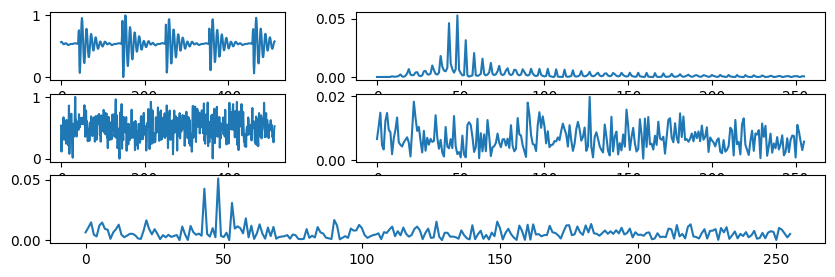

In [ ]:
from matplotlib import gridspec
s = 10
g_in = teb_in[0,0:1,:].detach().cpu().numpy()
tegen_data= p_sample_loop_CG_(model,model_CG,teb_out,[2,5,512],num_steps,betas.cuda(),one_minus_alphas_bar_sqrt.cuda(),s)
g_out = tegen_data[0,0:1,:].detach().cpu().numpy()
g_in = normalize(g_in)
g_out = normalize(g_out)
N = 512
g11 = (1/N)*np.abs(np.fft.fft(g_in.reshape(-1)))
g11_ = g11[1:int(N/2)+1]
g22 = (1/N)*np.abs(np.fft.fft(g_out.reshape(-1)))
g22_ = g22[1:int(N/2)+1]

anomaly_map = np.abs(g11_- g22_)
#anomaly_map = np.abs(g11_-g22_)



plt.figure(figsize = (10,3))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 2])
plt.subplot(gs[0,0])
plt.plot(g_in.reshape(-1))
plt.subplot(gs[0,1])
plt.plot(g11_.reshape(-1))
plt.subplot(gs[1,0])
plt.plot(g_out.reshape(-1))
plt.subplot(gs[1,1])
plt.plot(g22_.reshape(-1))
plt.subplot(gs[2,:])
plt.plot(anomaly_map.reshape(-1))